In [3]:
library(stringr)
library(dplyr)
library(ggplot2)
library(lubridate)
library(ISOweek)
library(scales)
library(zoo)
library(tidyr)
library(quantreg)
library(splines)
library(pbs)
library(forecast)
require(RcppRoll)
library(fpp2)
library(xts)
theme_set(theme_bw())
get_percentage = function(x) {
    (exp(x) - 1) * 100
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: timechange


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: RcppRoll

── Attaching packages ─────────────────────────────────────────────── fpp2 2.4 ──

✔ fma       2.4     ✔ expsmooth 2.3




Attaching package: ‘xts’


The following objects are masked from ‘package:dplyr’:

    first, last




In [35]:
# You can also redownload the data with the get_data.r script
# The data can be obtained from "https://www.mortality.org/File/GetDocument/Public/STMF/Outputs/stmf.csv"
df = read.csv("../data/stmf.csv", skip=1)
n_rows = nrow(df)
head(df)

CountryCode Year Week Sex D0_14    D15_64   D65_74 D75_84 D85p DTotal
1 AUS         2015 1    m   17.16683 358.8332 250    436     413 1475  
2 AUS         2015 1    f   13.96873 199.0313 183    350     704 1450  
3 AUS         2015 1    b   31.13556 557.8644 433    786    1117 2925  
4 AUS         2015 2    m   17.47338 334.5266 255    386     422 1415  
5 AUS         2015 2    f   11.49041 186.5096 162    322     675 1357  
6 AUS         2015 2    b   28.96379 521.0362 417    708    1097 2772  
  R0_14        R15_64      R65_74      R75_84     R85p      RTotal      Split
1 0.0003861406 0.002373081 0.013132615 0.04564277 0.1279923 0.006484000 1    
2 0.0003315331 0.001309212 0.009350468 0.03118472 0.1258493 0.006289413 1    
3 0.0003595696 0.001839719 0.011215354 0.03783231 0.1266332 0.006386056 1    
4 0.0003930360 0.002212334 0.013395268 0.04040851 0.1307814 0.006220244 1    
5 0.0002727127 0.001226845 0.008277463 0.02868994 0.1206652 0.005886024 1    
6 0.0003344888 0.001718267 0.010800930 0.03407796 0.1243659 0.006052016 1    
  SplitSex Forecast
1 0        0       
2 0        0       
3 0        0       
4 0        0       
5 0        0       
6 0        0

In [39]:
df["Weekday"] = "7"
df$Week = str_pad(df$Week, 2, pad="0")
data = df %>% unite(Weekdate, "Year", "Week", sep="-W", remove=FALSE)
data = data %>% unite(Weekdate, "Weekdate", "Weekday", sep="-")
# Deaths are recorded by ISO week, so we use the monday following the week end as a time stamp
# for each weekly death count
data$Date = ISOweek2date(data$Weekdate) + days(1)

In [40]:
death_cols = c("D0_14", "D15_64", "D65_74", "D75_84", "D85p")
rate_cols = c("R0_14", "R15_64", "R65_74", "R75_84", "R85p")
base_cols = c("CountryCode", "Weekdate", "Year", "Week", "Sex")
data = data %>% pivot_longer(all_of(c(death_cols, rate_cols)), names_pattern="(.)(.*)", names_to=c("Type", "Age")) %>% pivot_wider(names_from=Type, values_from=value)# data$Pop = data$Deaths / data$Rates
data = rename(data, Deaths = D)
data = rename(data, Rates = R)
data$Pop = data$Deaths / data$Rates

data = data %>% group_by(Age, Sex, CountryCode) %>% fill(Pop, .direction="up")
data$Pop_int = data$Pop
data$Pop_int[data$Week != 52] = NA
data = data[data$Week != 53, ]
data = data %>%
    group_by(Sex, Age, CountryCode) %>%
    arrange(Date) %>%
    mutate(time=seq(1, n())) %>% 
    mutate(Pop_int=approx(time,Pop_int,time)$y) %>%
    fill(Pop_int, .direction="downup") %>%
    select(-time)
data$Rate_norm = data$Deaths / data$Pop_int

# European Standard population numbers
# Get the ESP groups
std_esp_pop = c(1000, 4000, 5500, 5500, 5500, 6000, 6000, 6500, 7000, 
            7000, 7000, 7000, 6500, 6000, 5500, 5000, 4000, 2500, 1500, 800, 200)
esp_group = cut(c(0:100), c(0,1,seq(5,95, 5), 200), right=FALSE)
age = c("0_14", "15_64", "65_74", "75_84", "85p")
esp_pop = c(sum(std_esp_pop[1:4]), sum(std_esp_pop[5:14]), sum(std_esp_pop[15:16]), sum(std_esp_pop[17:18]), sum(std_esp_pop[19:21]))
esp_df = data.frame(Age=age, Esp_pop=esp_pop)
esp_groups = levels(esp_group)
std_esp_df = data.frame(age=esp_groups, esp_pop=std_esp_pop)
data = merge(data, esp_df, by="Age")
data$Deaths_norm = data$Rate_norm * data$Esp_pop
sprintf("Fraction of data missing %.2f", dim(data[data$Deaths_norm==0,])[1] / dim(data)[1])
# With a smoother we are down to 3%. This is managable
# Define functions
weighted_mean = function(x) {
    nas = is.na(x)
    w = c(0.25, 0.5, 0.25)
    if (all(nas)) {
        return(0)
    } else {
        w = w[!nas] / sum(w[!nas])
        return(sum(x[!nas] * w))
    }
}
sprintf("Smoothing...")
data <- data %>% group_by(Age, CountryCode, Sex) %>% arrange(Sex, Age, Date) %>%
       mutate(Sdeaths_norm=rollapply(Deaths_norm, 3, weighted_mean, align='center', fill=NA))
sprintf("Fraction of data missing after smoothing %.2f", dim(data[data$Sdeaths_norm==0,])[1] / dim(data)[1])

data = data %>% fill(Sdeaths_norm, .direction="downup") %>% filter(Sdeaths_norm > 0)

head(data)

[1] "Fraction of data missing 0.02"

[1] "Smoothing..."

[1] "Fraction of data missing after smoothing 0.01"

Age  CountryCode Weekdate   Year Week Sex DTotal RTotal     Split SplitSex
1 0_14 FIN         1990-W01-7 1990 01   b   1146   0.01194916 0     0       
2 0_14 FIN         1990-W02-7 1990 02   b   1139   0.01187618 0     0       
3 0_14 FIN         1990-W03-7 1990 03   b   1185   0.01235581 0     0       
4 0_14 FIN         1990-W04-7 1990 04   b   1164   0.01213685 0     0       
5 0_14 FIN         1990-W05-7 1990 05   b   1103   0.01150081 0     0       
6 0_14 FIN         1990-W06-7 1990 06   b   1065   0.01110459 0     0       
  Forecast Date       Deaths Rates        Pop      Pop_int  Rate_norm   
1 0        1990-01-08 14     0.0007558188 18522.96 18522.96 0.0007558188
2 0        1990-01-15 10     0.0005398706 18522.96 18522.96 0.0005398706
3 0        1990-01-22 12     0.0006478447 18522.96 18522.96 0.0006478447
4 0        1990-01-29  7     0.0003779094 18522.96 18522.96 0.0003779094
5 0        1990-02-05 10     0.0005398706 18522.96 18522.96 0.0005398706
6 0        1990-02-12 11     0.0005938576 18522.96 18522.96 0.0005938576
  Esp_pop Deaths_norm Sdeaths_norm
1 16000   12.093101   9.933619    
2 16000    8.637929   9.933619    
3 16000   10.365515   8.853877    
4 16000    6.046550   7.774136    
5 16000    8.637929   8.206033    
6 16000    9.501722   7.558188

In [41]:
mortality_fit = function(
    data, 
    # Parameters
    years_per_df = 5,
    df.weekly = 4,
    df.res = 2,
    alpha=0.10,
    response.col = "Sdeaths_norm",
    debug=FALSE,
    cv=FALSE) {
    # This function fits trends and confidence intervals at the alpha level
    # Enforced column names in input data
    
    test_start_year = 2020
    start_year = 2012
    
    week.col = "Week"
    year.col = "Year"
    date.col = "Date"
    sex.col = "Sex"
    country.col = "CountryCode"
    age.col = "Age"
    pop.col = "Pop_int"

    all = data.frame(date = data[,date.col],
                    week = as.numeric(unlist(data[,week.col])),
                    year = as.numeric(unlist(data[,year.col])),
                    response=log(data[, response.col]),
                    sex = as.factor(unlist(data[,sex.col])),
                    country = as.factor(unlist(data[,country.col])),
                    age = as.factor(unlist(data[,age.col])),
                    pop = as.factor(unlist(data[,pop.col])))
    
    colnames(all) = c("date", "week", "year", "response", "sex", "country", "age", "pop")
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    print(sprintf("Using %d degrees of freedom in yearly splines for %s, %s, %s", 
            df.yearly, all$country[1], all$age[1], all$sex[1]))
    all = subset(all, year(date) > start_year)
    train = subset(all, year(date) < test_start_year)
    test = subset(all, year(date) >= test_start_year)

    yearly.fit = rq(response ~ ns(date, df=df.yearly), data=train)

    train[, "res.yearly"] = yearly.fit$res
    train[, "fit.yearly"] = yearly.fit$fit
    weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=df.weekly), data=train)
    
    train[, "fit.weekly"] = weekly.fit$fit
    train[, "res.weekly"] = weekly.fit$res
    train = train %>% mutate(centered = response - fit.weekly - fit.yearly)
    # Set test date to last train date to fix yearly trend in test period
    mod_date = all$date
    mod_date[year(mod_date) >= test_start_year] = as.Date("2019-12-31", "%Y-%m-%d")
    mod_all = data.frame(date=mod_date, week=all$week)
    all$fit.yearly = predict(yearly.fit, newdata=mod_all)
    all$fit.weekly = predict(weekly.fit, newdata=mod_all)
    
    all = all %>% mutate(centered = response - fit.weekly - fit.yearly)
    n_train = nrow(train)
    n_all = nrow(all)
    # Simple constant quantile c.i.
    if (df.res <= 2) {
        fit.low = quantile(train$centered, alpha/2)
        fit.high = quantile(train$centered, 1 - alpha/2)
        train$centered_high = rep(fit.high, n_train)
        train$centered_low = rep(fit.low, n_train)
        all$centered_high = rep(fit.high, n_all)
        all$centered_low = rep(fit.low, n_all)
    } else {
        fit.low = rq(centered ~ 0 + pbs(week, df=df.res), data=train, tau=alpha/2)
        fit.high = rq(centered ~ 0 + pbs(week, df=df.res), data=train, tau=1-alpha/2)
        train$centered_high = fit.high$fit
        train$centered_low = fit.low$fit
        all$centered_high = predict(fit.high, newdata=all)
        all$centered_low = predict(fit.low, newdata=all)
    }
    
    test = subset(all, year(date) > 2020)
    frac_outside = sum(train$centered < train$centered_low | train$centered > train$centered_high) / nrow(train)
    frac_outside_test = sum(test$centered < test$centered_low | test$centered > test$centered_high) / nrow(test)
    frac_over_test = sum(test$centered > test$centered_high) / nrow(test)
    if (debug) {
        print(sprintf("Fraction of observations outside confidence band in pre-2020: %.3f", frac_outside))
        print(sprintf("Fraction of observations outside confidence band in 2021: %.3f", frac_outside_test))
        print(sprintf("Fraction of observations over confidence band in 2021: %.3f", frac_over_test))
    }
    if (cv) {
        return(list(df=all, weekly.fit=weekly.fit))
    }
    return(all)
}

plot_debug = function(df) {
    ggplot(df, aes(date, response)) + geom_line(alpha=0.3) + 
    geom_line(aes(date, fit.yearly), size=1.5, color="blue") + 
    geom_line(aes(date, fit.weekly + fit.yearly), size=1.5, color="gold") +
    geom_ribbon(aes(ymin=centered_low + fit.weekly + fit.yearly, 
                    ymax=centered_high + fit.weekly + fit.yearly), alpha=0.3) + 
    labs(x="Date", y="Deaths [per 100k per week]", title="Anomalous Mortality 2012-2022") 
}
plot_mortality = function(df) {
    ggplot(df, aes(date, get_percentage(centered))) + geom_line(alpha=0.3) + 
    geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
    geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
    labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") 

}

In [42]:
stratified = data %>% group_by(CountryCode, Sex, Age) %>% group_map(~ mortality_fit(.x, response.col="Sdeaths_norm"), keep=TRUE)
stratified = do.call(rbind, stratified)
# stratified_dfres = data %>% group_by(CountryCode, Sex, Age) %>% group_map(~ mortality_fit(.x, response.col="Sdeaths_norm", df.res=6), keep=TRUE)
# stratified_dfres = do.call(rbind, stratified_dfres)

[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 85p, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 85p, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 0_14, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15_64, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65_74, m"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 75_84, m"
[1] "Using 2 degrees of freedom in yearly

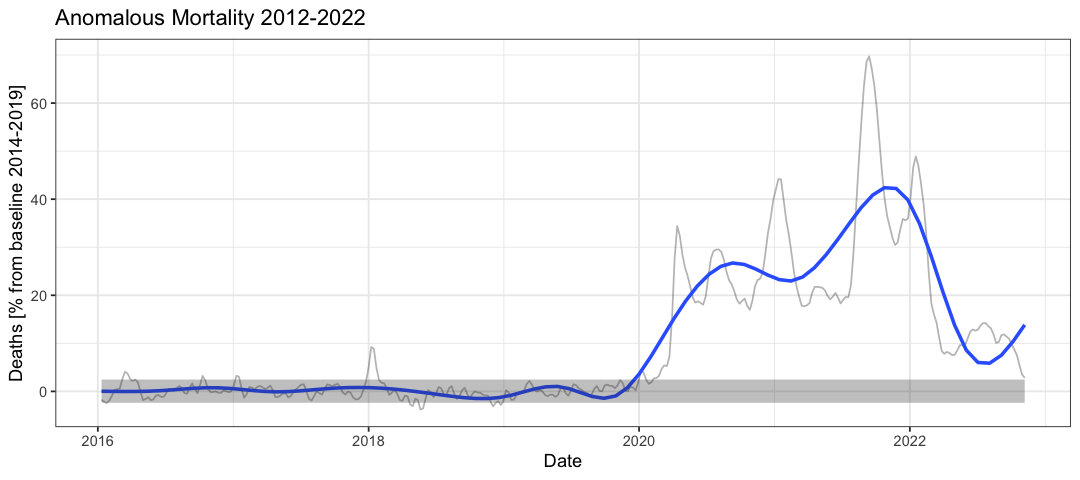

In [43]:
# Subset
options(repr.plot.width=9, repr.plot.height=4)
plot_mortality(subset(stratified, country=="USA" & age=="15_64" & sex=="b" & year >= 2016))
# plot_mortality(subset(stratified_dfres, country=="USA" & age=="15_64" & sex=="b" & year >= 2016))
# plot_mortality(subset(stratified, country==country & age=="65_74" & sex=="b"))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


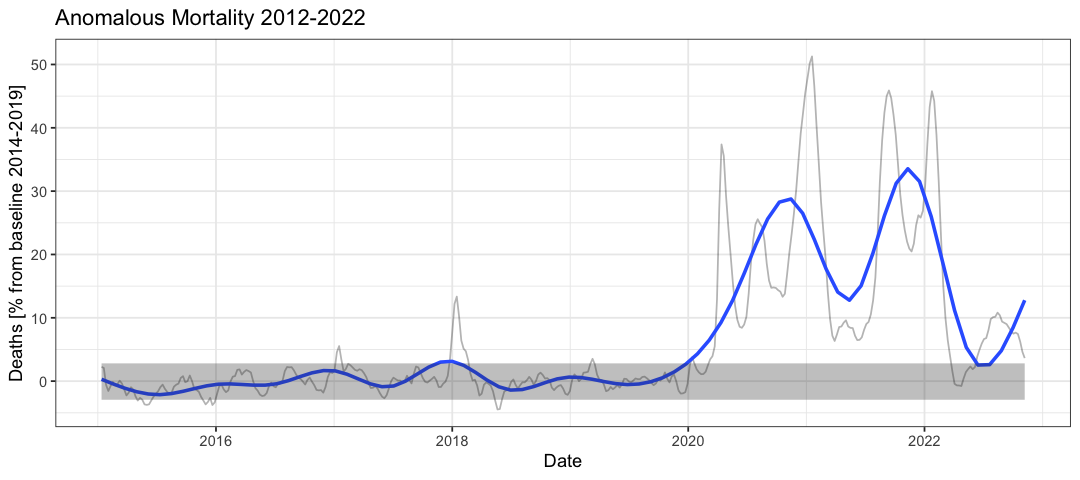

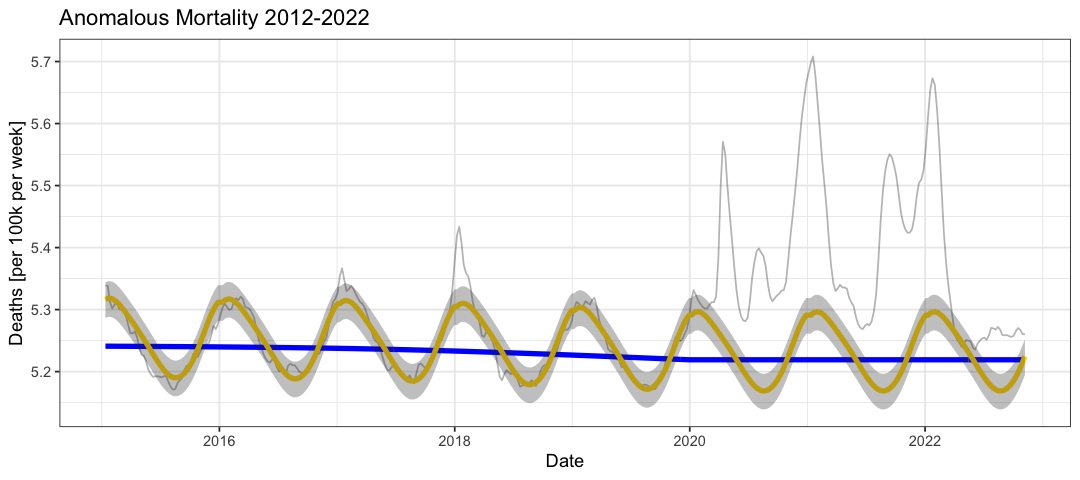

In [44]:
# Subset
options(repr.plot.width=9, repr.plot.height=4)
# cdata = subset(stratified, country=="NOR" & age=="65_74" & sex=="b" & Sdeaths_norm > 0)
# all = mortality_fit(cdata, response.col="Sdeaths_norm")
countrysub = subset(stratified, country=="USA" & age=="65_74" & sex=="b" & year >= 2012)
plot_mortality(countrysub)
plot_debug(countrysub)

In [45]:
# Sum age groups' deaths and population
high_ages = subset(data, Age %in% c("65_74", "74_85", "85p")) %>% group_by(Date, CountryCode, Sex) %>% 
    summarise(Sdeaths_norm=sum(Sdeaths_norm), Pop_int=sum(Pop_int),
             Date=Date, Week=Week, Year=Year, Age="65+") %>% distinct()
mid_ages = subset(data, Age %in% c("15_64")) %>% group_by(Date, CountryCode, Sex) %>% 
    summarise(Sdeaths_norm=sum(Sdeaths_norm), Pop_int=sum(Pop_int),
             Date=Date, Week=Week, Year=Year, Age="15-64") %>% distinct()
adult_ages = subset(data, Age %in% c("15_64","65_74", "74_85", "85p")) %>% group_by(Date, CountryCode, Sex) %>% 
    summarise(Sdeaths_norm=sum(Sdeaths_norm), Pop_int=sum(Pop_int),
             Date=Date, Week=Week, Year=Year, Age="15+") %>% distinct()

`summarise()` has grouped output by 'Date', 'CountryCode', 'Sex'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'Date', 'CountryCode'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Date', 'CountryCode', 'Sex'. You can
override using the `.groups` argument.


In [46]:
# Fit all countries
res_high = high_ages %>% group_by(CountryCode, Sex) %>% group_map(~ mortality_fit(.x), keep=TRUE)
high_ages_df = do.call(rbind, res_high)
res_mid = mid_ages %>% group_by(CountryCode, Sex) %>% group_map(~ mortality_fit(.x), keep=TRUE)
mid_ages_df = do.call(rbind, res_mid)
res_adult = adult_ages %>% group_by(CountryCode, Sex) %>% group_map(~ mortality_fit(.x), keep=TRUE)
adult_ages_df = do.call(rbind, res_adult)

all_ages_df = rbind(high=high_ages_df, mid=mid_ages_df, adult=adult_ages_df)
all_ages_df$age_group = rownames(all_ages_df)
all_ages_df$age_group = gsub("\\.*\\d", "", all_ages_df$age_group)
all_ages_df$age_group = gsub(".Sex", "", all_ages_df$age_group)

[1] "Using 2 degrees of freedom in yearly splines for AUS, 65+, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65+, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 65+, m"
[1] "Using 4 degrees of freedom in yearly splines for AUT, 65+, b"
[1] "Using 4 degrees of freedom in yearly splines for AUT, 65+, f"
[1] "Using 4 degrees of freedom in yearly splines for AUT, 65+, m"
[1] "Using 4 degrees of freedom in yearly splines for BEL, 65+, b"
[1] "Using 4 degrees of freedom in yearly splines for BEL, 65+, f"
[1] "Using 4 degrees of freedom in yearly splines for BEL, 65+, m"
[1] "Using 4 degrees of freedom in yearly splines for BGR, 65+, b"
[1] "Using 4 degrees of freedom in yearly splines for BGR, 65+, f"
[1] "Using 4 degrees of freedom in yearly splines for BGR, 65+, m"
[1] "Using 2 degrees of freedom in yearly splines for CAN, 65+, b"
[1] "Using 2 degrees of freedom in yearly splines for CAN, 65+, f"
[1] "Using 2 degrees of freedom in yearly splines for CAN, 65+

[1] "Using 2 degrees of freedom in yearly splines for AUS, 15+, b"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15+, f"
[1] "Using 2 degrees of freedom in yearly splines for AUS, 15+, m"
[1] "Using 4 degrees of freedom in yearly splines for AUT, 15+, b"
[1] "Using 4 degrees of freedom in yearly splines for AUT, 15+, f"
[1] "Using 4 degrees of freedom in yearly splines for AUT, 15+, m"
[1] "Using 4 degrees of freedom in yearly splines for BEL, 15+, b"
[1] "Using 4 degrees of freedom in yearly splines for BEL, 15+, f"
[1] "Using 4 degrees of freedom in yearly splines for BEL, 15+, m"
[1] "Using 4 degrees of freedom in yearly splines for BGR, 15+, b"
[1] "Using 4 degrees of freedom in yearly splines for BGR, 15+, f"
[1] "Using 4 degrees of freedom in yearly splines for BGR, 15+, m"
[1] "Using 2 degrees of freedom in yearly splines for CAN, 15+, b"
[1] "Using 2 degrees of freedom in yearly splines for CAN, 15+, f"
[1] "Using 2 degrees of freedom in yearly splines for CAN, 15+

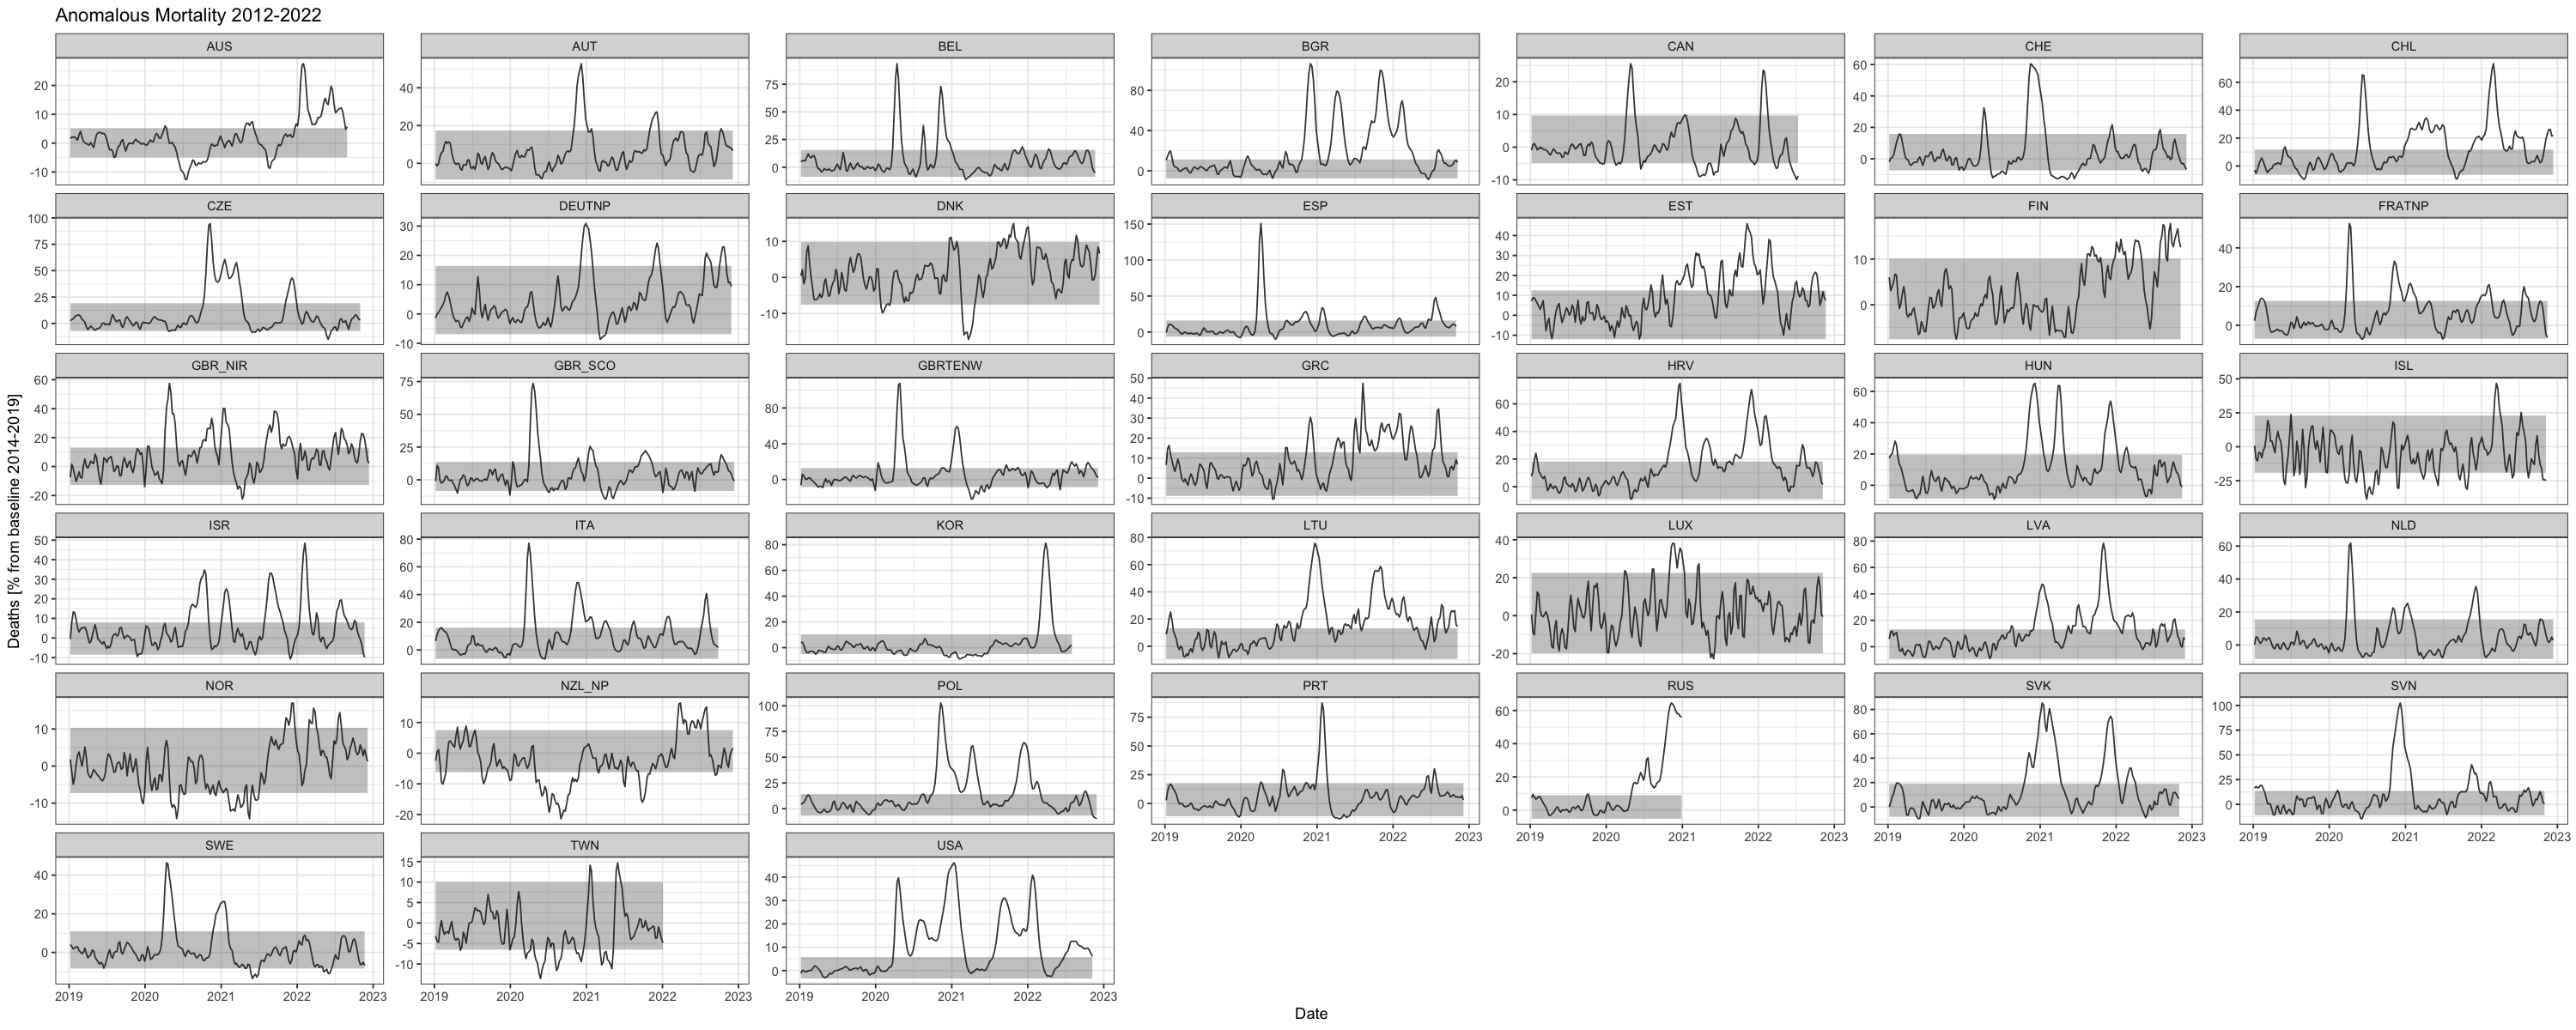

In [47]:
options(repr.plot.width=25, repr.plot.height=10)
p = ggplot(subset(all_ages_df, age_group=="high" & sex=="b" & year >= 2019), aes(date, get_percentage(centered))) + geom_line(alpha=0.8) + 
# geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~country, scales="free_y")
p
ggsave(p,file="../figures/all_countries_smooth_high_age.pdf", width=25, height=10)

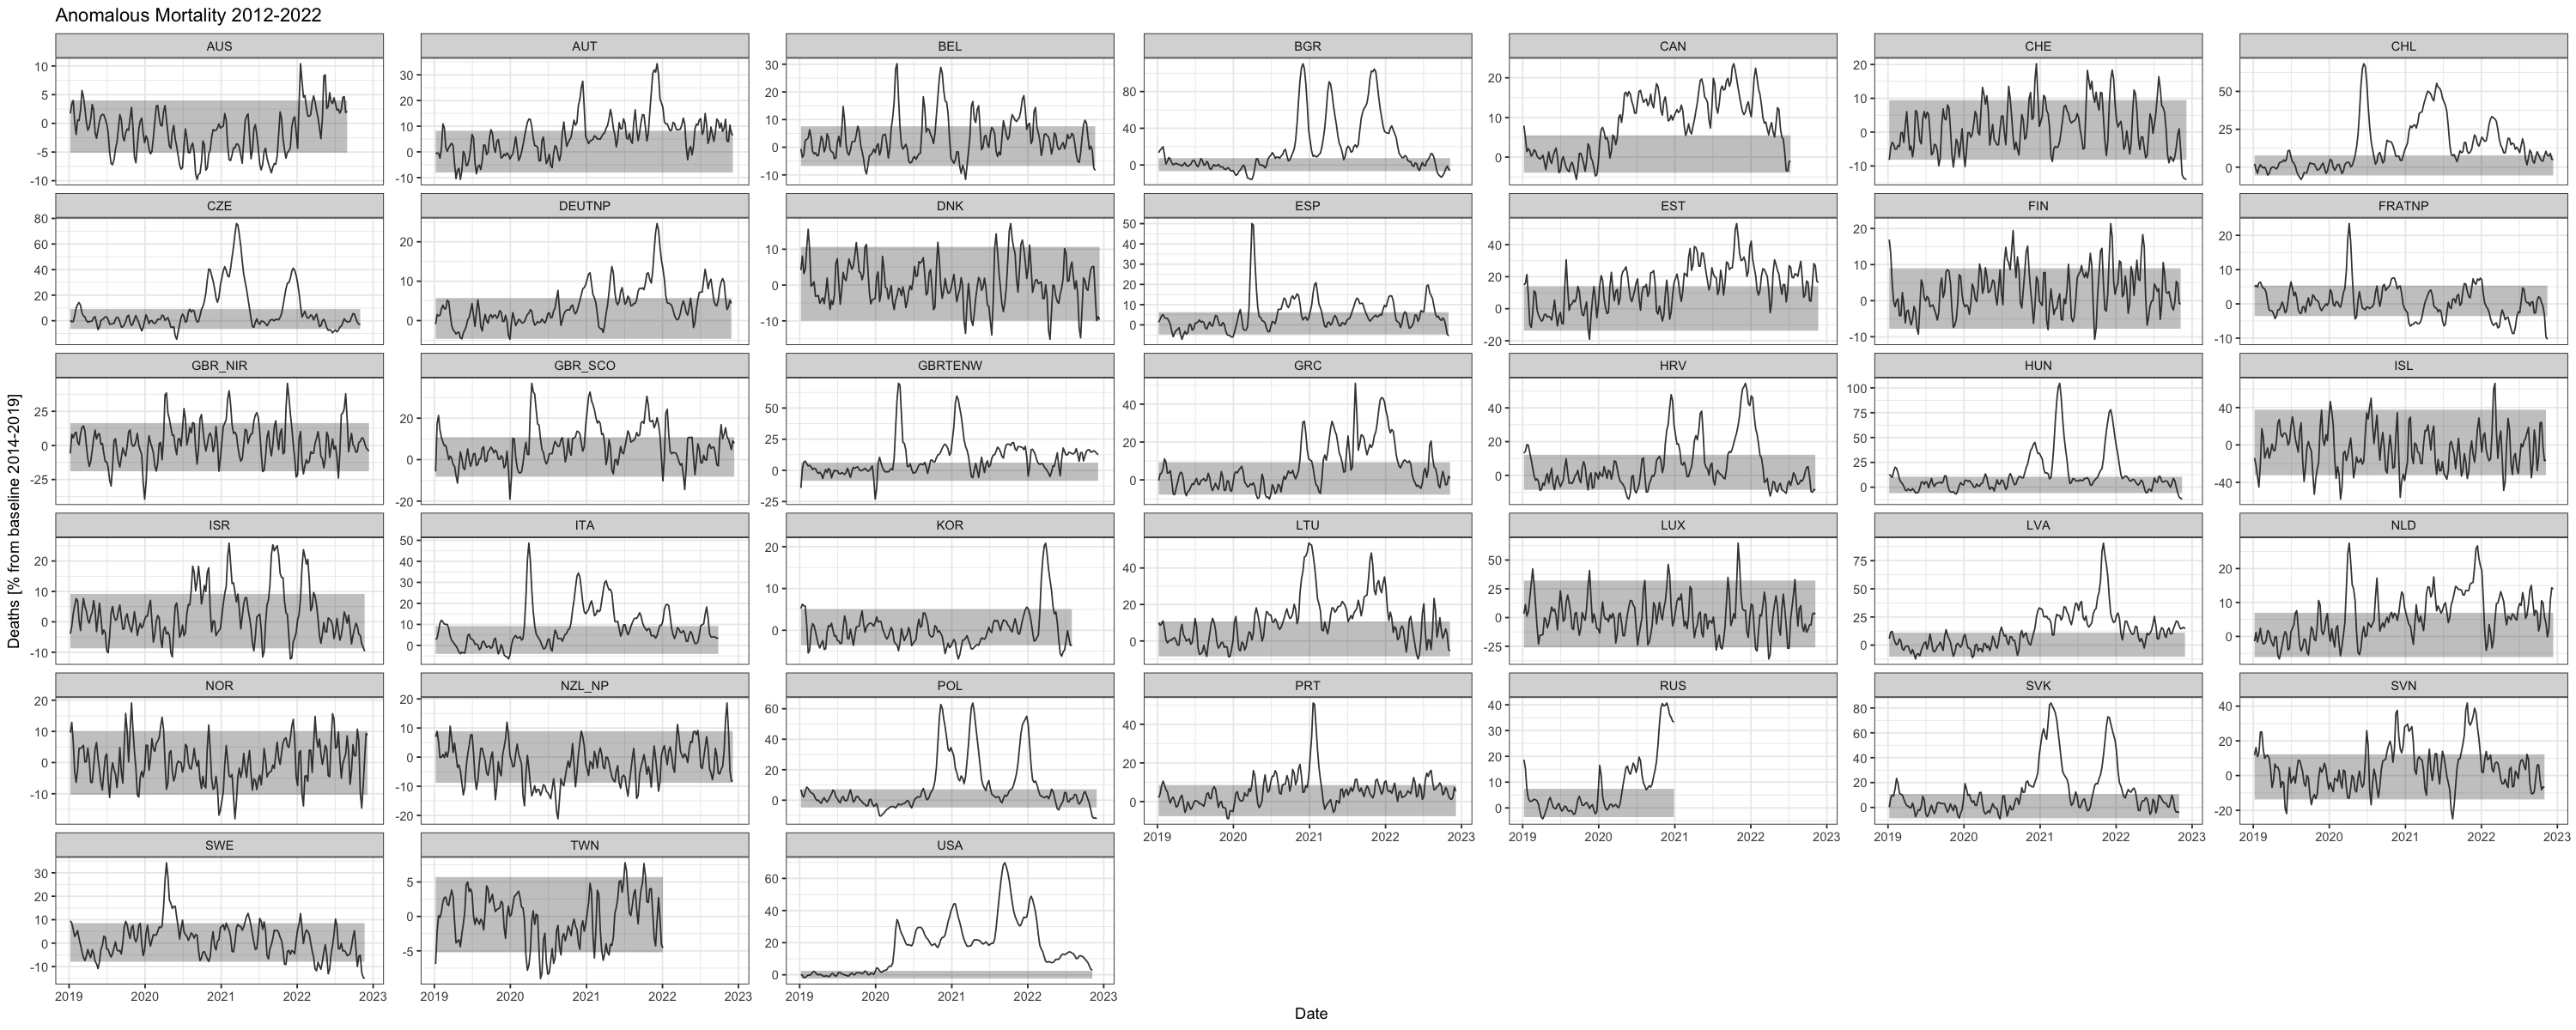

In [48]:
options(repr.plot.width=25, repr.plot.height=10)
p = ggplot(subset(mid_ages_df, sex=="b" & year >= 2019), aes(date, get_percentage(centered))) + geom_line(alpha=0.8) + 
# geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high)), alpha=0.3) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~country, scales="free_y")
p
ggsave(p,file="../figures/all_countries_smooth_mid_age.pdf", width=25, height=10)

In [49]:
# Cross-validate to find best smoothing parameter by minimizing out-of-sample 
# deviation from estimated exceedence. I.e. for a 95% confidence band, we will expect 
# 5% of out-of-sample estimates to be outside this band. We thus choose the smallest number 
# of parameters that get us there.
# Conclusion: The predictive power is not dependent on degrees of freedom of smoothing
# options(repr.plot.width=7, repr.plot.height=4)
cv_mortality = function(cdata,
                       years_per_df = 5,
                       test_start_year = 2020,
                       cv_type="week",  # week or "res" for residuals spline degrees of freedom
                       dfs=c(2, 4, 6, 8, 10, 12, 14, 16, 18, 20),
                       df_other=2,
                       response="Sdeaths_norm") {

    # TODO: make df_opther into a vector of same length as dfs
    
    all = cdata %>% rename(week=Week, year=Year, age=Age, date=Date, country=CountryCode, sex=Sex, 
                     response=all_of(response))
    all$week = as.numeric(all$week)
    all$year = as.numeric(all$year)
    
    df.yearly = floor(max((test_start_year - min(all$year)) / years_per_df, 2))
    train = subset(all, year < 2020 & year > 2012)
    alpha = 0.05 # Confidence interval

    years = unique(train$year)
    n_years = length(years)
    n_dfs = length(dfs)
    te_hat = matrix(0, n_years, n_dfs)
    tr_hat = matrix(0, n_years, n_dfs)
    sd_ratio_hat = matrix(0, n_years, n_dfs)
    INFL = 1.
    out = vector(mode="list", length=n_years)
    if (cv_type == "week") {
        dfs_week = dfs
        dfs_res = rep(df_other, length(dfs))
    } else if (cv_type == "res") {
        dfs_res = dfs
        dfs_week = rep(df_other, length(dfs))
    }

    for (i in 1:n_years) {
        out[[i]] = vector(mode="list", length=n_dfs)

        for (j in 1:n_dfs) {
            m_year = years[i]
            
            tr = subset(train, year != m_year)
            te = subset(train, year == m_year)
            n_tr = nrow(tr)
            n_te = nrow(te)
            yearly.fit = rq(response ~ ns(date, df=df.yearly), data=tr)

            tr[, "res.yearly"] = yearly.fit$res
            tr[, "fit.yearly"] = yearly.fit$fit

            if (dfs_week[j] <= 2) {
                weekly.fit = rq(res.yearly ~ week, data=tr)
            } else {
                weekly.fit = rq(res.yearly ~ 0 + pbs(week, df=dfs_week[j]), data=tr)
            }

            tr[, "fit.weekly"] = weekly.fit$fit
            tr[, "res.weekly"] = weekly.fit$res
            tr = tr %>% mutate(centered = response - fit.weekly - fit.yearly)
            te$fit.yearly = predict(yearly.fit, newdata=te)
            te$fit.weekly = predict(weekly.fit, newdata=te)

            te = te %>% mutate(centered = response - fit.weekly - fit.yearly)

            if (dfs_res[j] <= 2) {
                fit.low = quantile(tr$centered, alpha/2)
                fit.high = quantile(tr$centered, 1 - alpha/2)      
                tr$high = rep(fit.high, n_tr)
                tr$low = rep(fit.low, n_tr)
                te$high = rep(fit.high, n_te)
                te$low = rep(fit.low, n_te)
            } else {
                fit.low = rq(centered ~ 0 + pbs(week, df=dfs_res[j]), data=tr, tau=alpha/2)
                fit.high = rq(centered ~ 0 + pbs(week, df=dfs_res[j]), data=tr, tau=1-alpha/2)
                tr$high = fit.high$fit
                tr$low = fit.low$fit
                te$high = predict(fit.high, newdata=te)
                te$low = predict(fit.low, newdata=te)
            }
            
            sd_ratio_hat[i, j] = sd(te$centered) / sd(tr$centered)
            tr_hat[i, j] = 1 - (sum(tr$low > tr$centered | tr$high < tr$centered) / nrow(tr))
            te_hat[i, j] = 1 - (sum(te$low > te$centered | te$high < te$centered) / nrow(te))
        }
    }
    
    te_oos_error = data.frame(mean=apply(te_hat, 2, median), upper=apply(te_hat, 2, quantile, .75), lower=apply(te_hat, 2, quantile, .25), dfs=dfs)
    tr_oos_error = data.frame(mean=apply(tr_hat, 2, median), upper=apply(tr_hat, 2, quantile, .75), lower=apply(tr_hat, 2, quantile, .25), dfs=dfs)
    oos_error = rbind(train=tr_oos_error, test=te_oos_error)
    oos_error$data_set = rownames(oos_error)
    oos_error$data_set = gsub("\\.*\\d", "", oos_error$data_set)
    oos_error$sex = all$sex[1]  # all rows in input must be same sex
    oos_error$country = all$country[1]  # all rows in input must be same sex
    return(oos_error)
}

In [50]:
oos_error = cv_mortality(high_ages %>% filter(CountryCode == "USA" & Sex == "b"))
tail(oos_error)

mean      upper     lower     dfs data_set sex country
test.5  0.9230769 0.9230769 0.9230769 10  test     b   USA    
test.6  0.9230769 0.9230769 0.9230769 12  test     b   USA    
test.7  0.9230769 0.9423077 0.8846154 14  test     b   USA    
test.8  0.9038462 0.9423077 0.9038462 16  test     b   USA    
test.9  0.9230769 0.9423077 0.8846154 18  test     b   USA    
test.10 0.9038462 0.9423077 0.8846154 20  test     b   USA

In [51]:
oos_error = cv_mortality(high_ages %>% filter(CountryCode == "USA" & Sex == "b"), cv_type="res", df_other=4)
tail(oos_error)

mean      upper     lower     dfs data_set sex country
test.5  0.8846154 0.8846154 0.8269231 10  test     b   USA    
test.6  0.8076923 0.8461538 0.7692308 12  test     b   USA    
test.7  0.7884615 0.8653846 0.7500000 14  test     b   USA    
test.8  0.7884615 0.8076923 0.7500000 16  test     b   USA    
test.9  0.8269231 0.8269231 0.8076923 18  test     b   USA    
test.10 0.7884615 0.8076923 0.7307692 20  test     b   USA

In [52]:
cv_high_ages = subset(high_ages, Sex=="b") %>% group_by(CountryCode) %>% group_map(~ cv_mortality(.x), keep=TRUE)

Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau = tau, ...):
“Solution may be nonunique”
Warning message in rq.fit.br(x, y, tau =

In [53]:
# Cross-validate residual envelopes/quantiles degrees of freedom while keeping the weekly estimates fixed
cv_res_high_ages = subset(high_ages, Sex=="b") %>% group_by(CountryCode) %>% 
    group_map(~ cv_mortality(.x, cv_type="res", df_other=4), keep=TRUE)

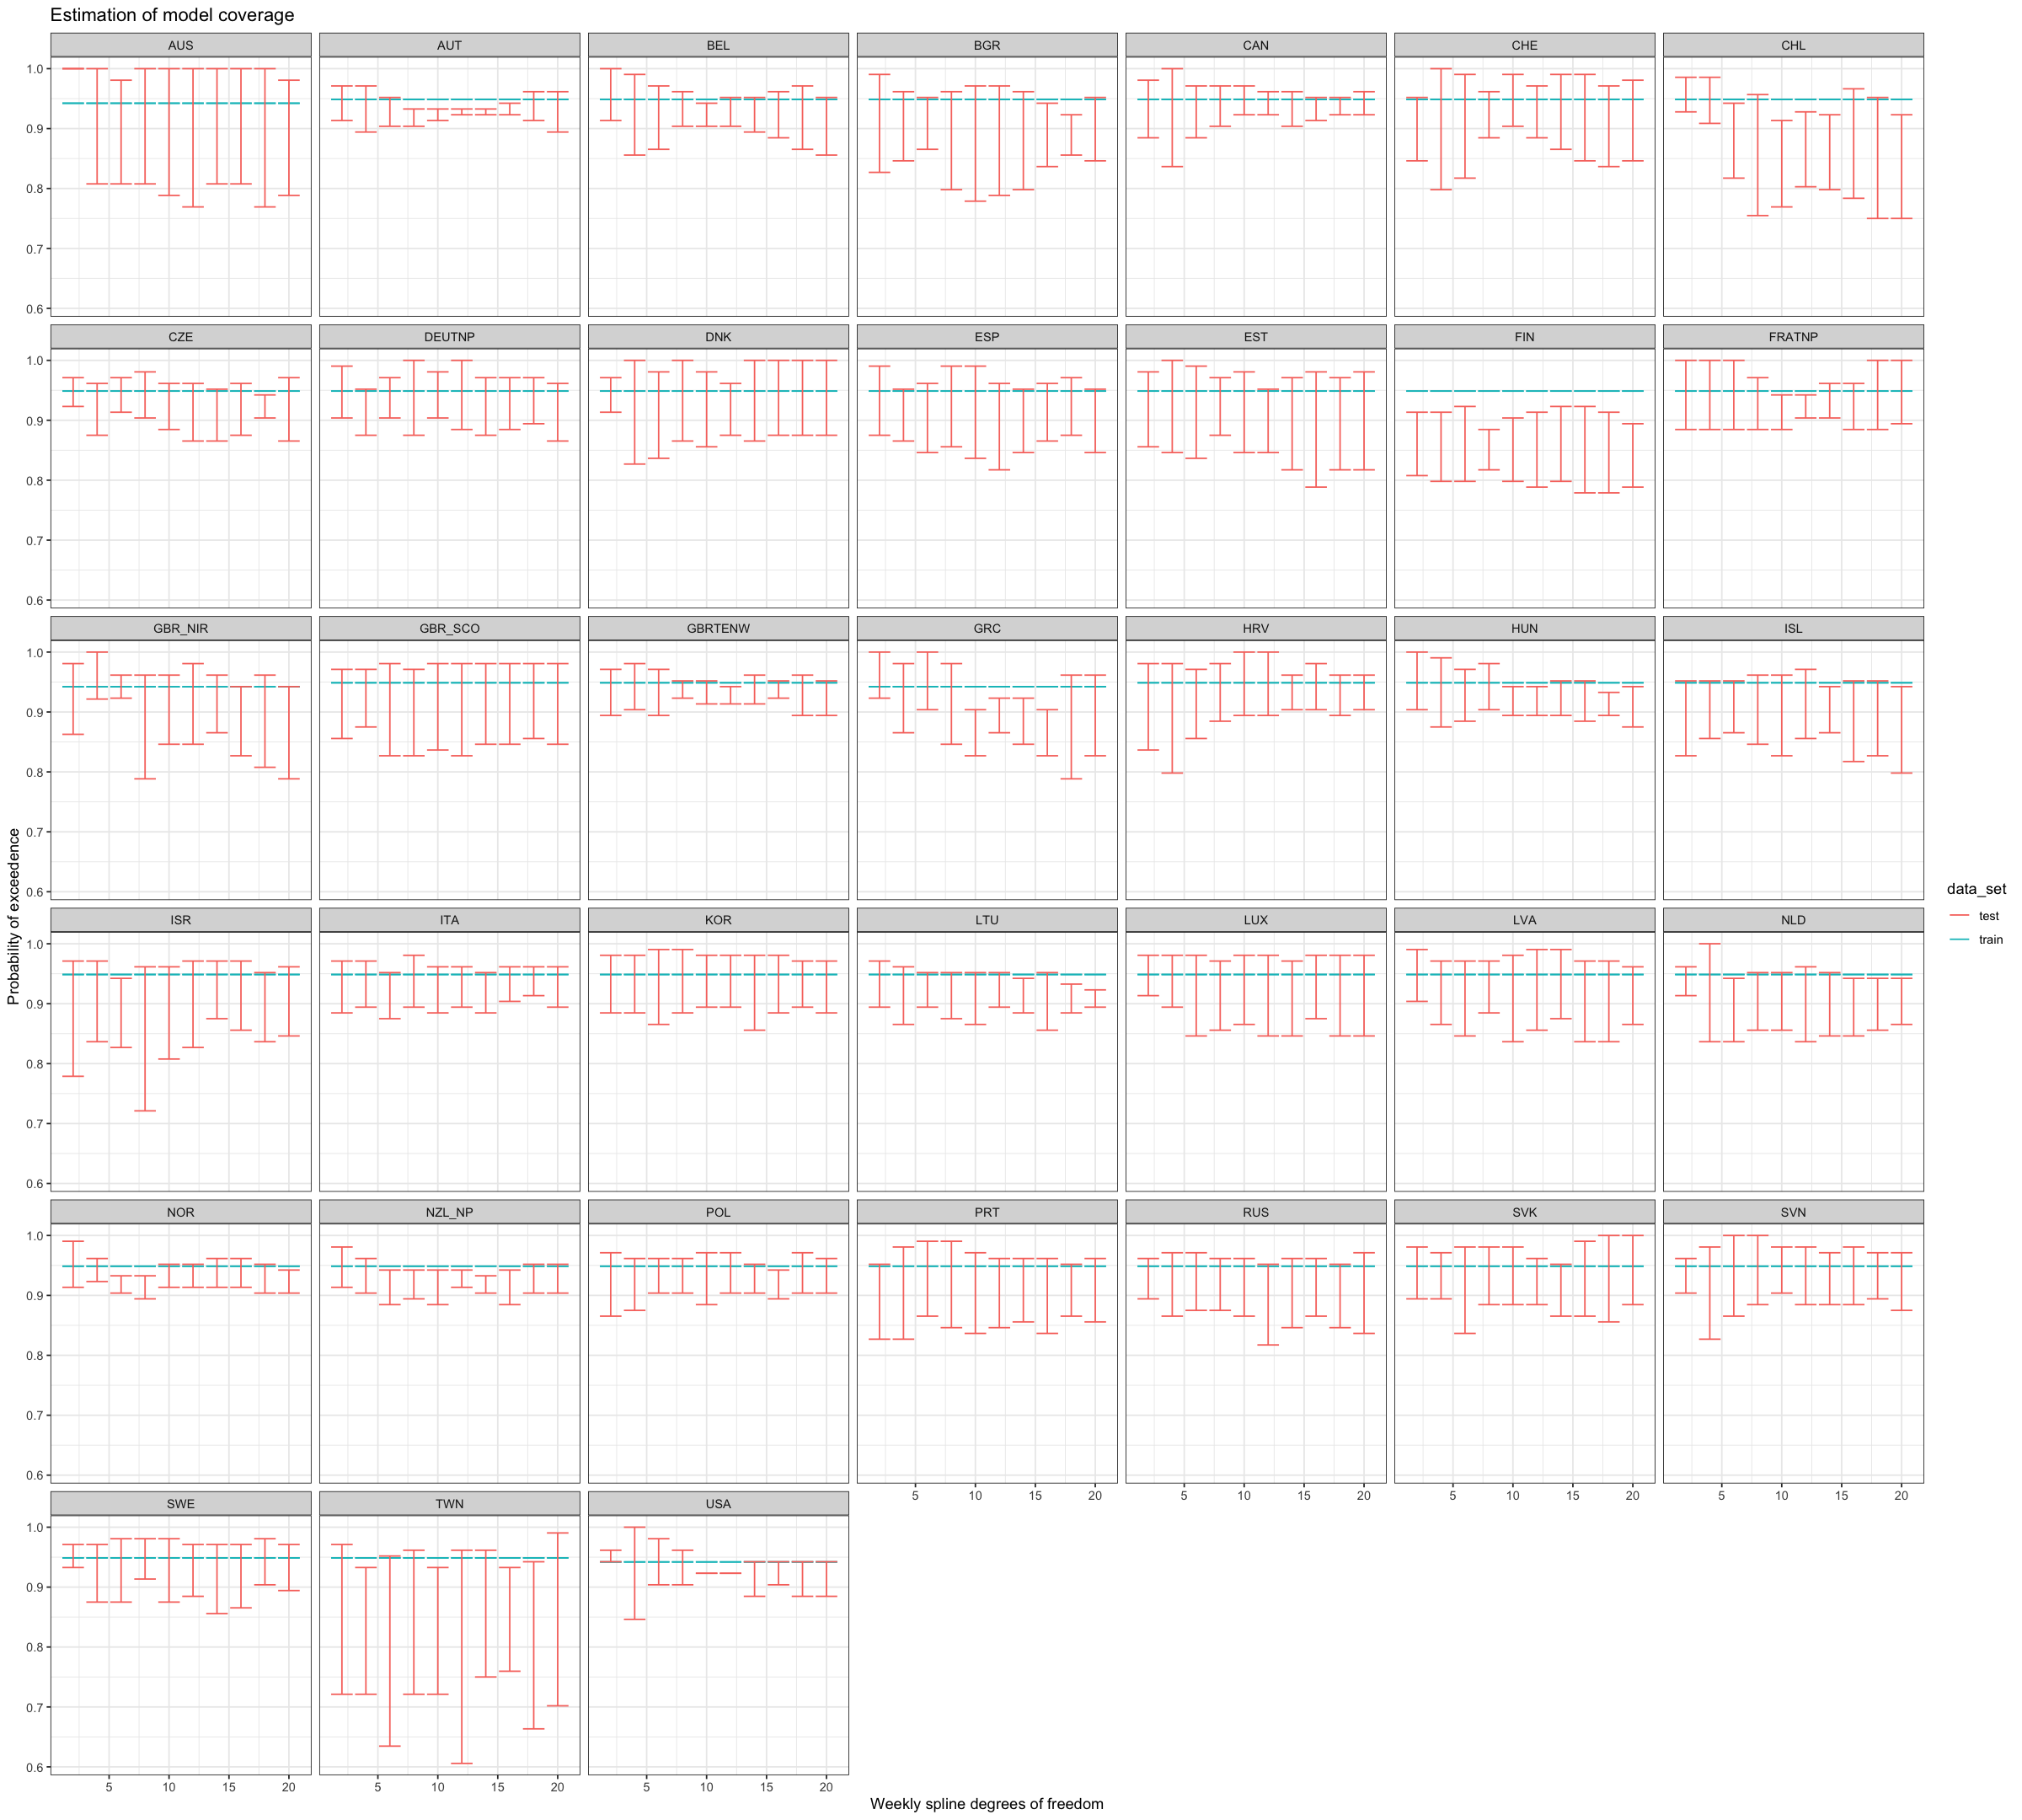

In [54]:
options(repr.plot.width=20, repr.plot.height=18)
p = ggplot(do.call(rbind, cv_high_ages),
      aes(x=dfs, mean, ymin=lower, ymax=upper, color=data_set)) + geom_errorbar() +
    theme_bw() +
    facet_wrap(~country) +
    labs(y="Probability of exceedence", x="Weekly spline degrees of freedom", 
    title="Estimation of model coverage")
p
ggsave(p, file="../figures/all_countries_cv.pdf", width=20, height=15)

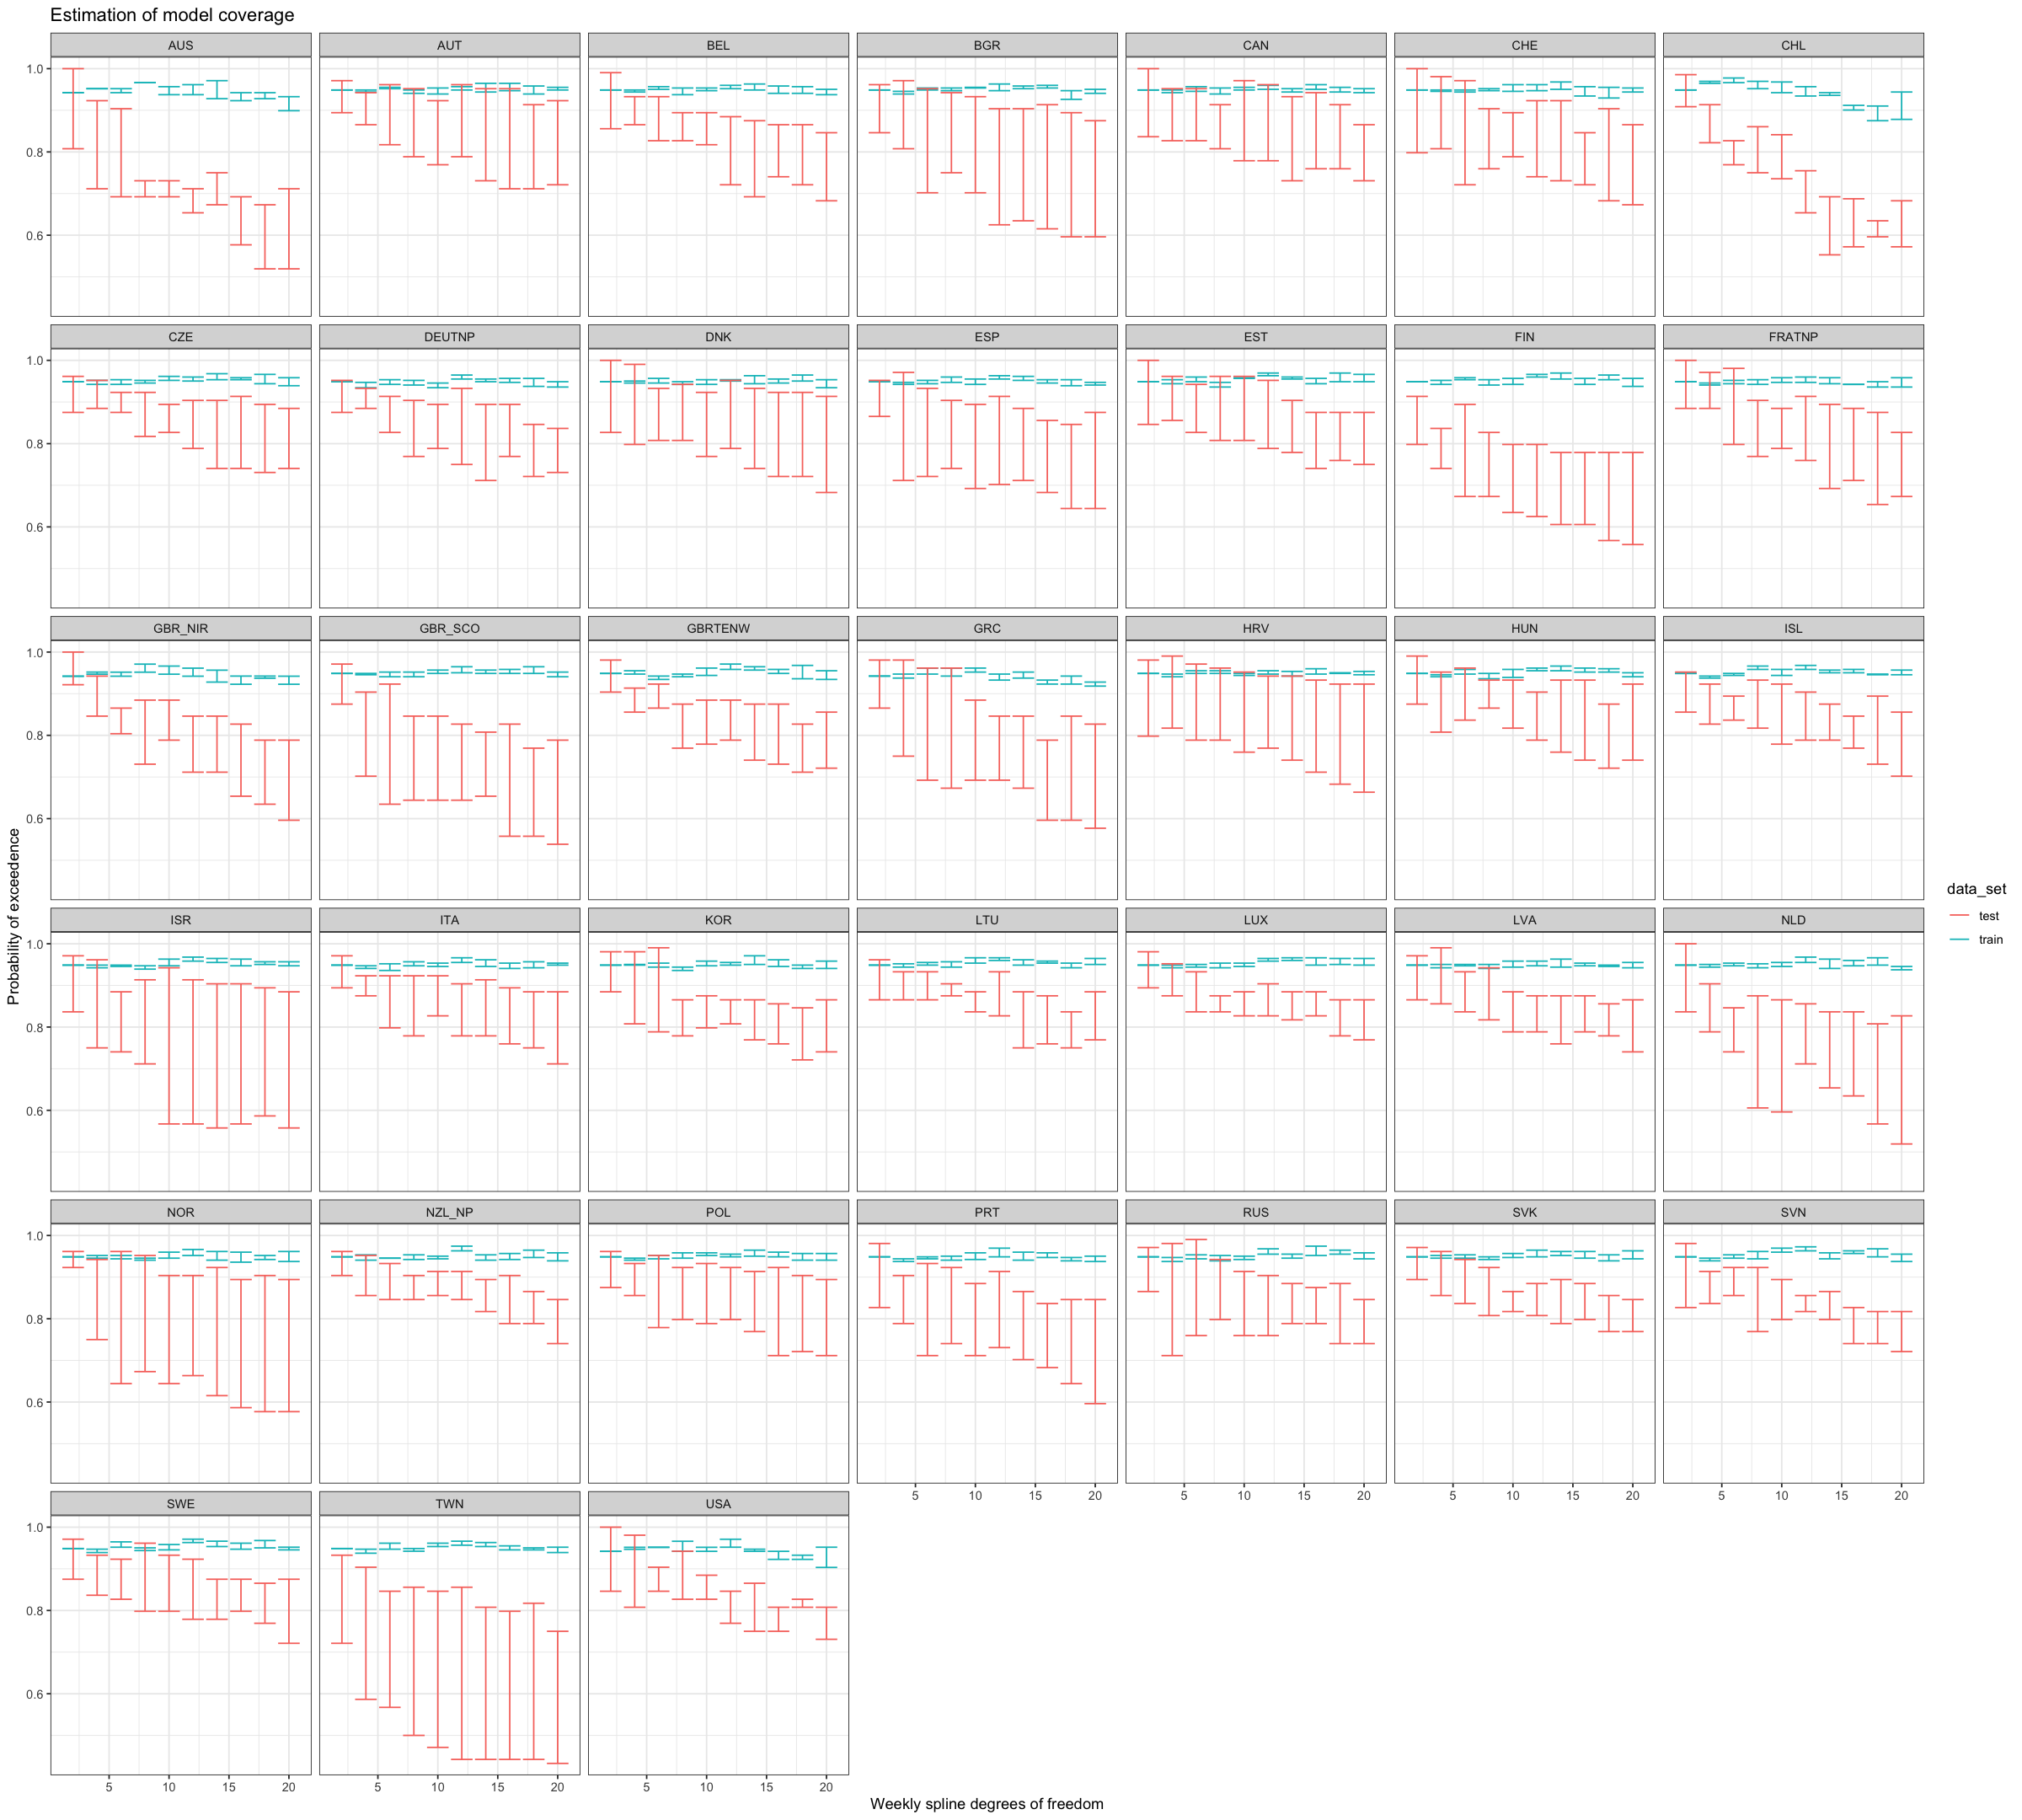

In [55]:
options(repr.plot.width=20, repr.plot.height=18)
p = ggplot(do.call(rbind, cv_res_high_ages),
      aes(x=dfs, mean, ymin=lower, ymax=upper, color=data_set)) + geom_errorbar() +
    theme_bw() +
    facet_wrap(~country) +
    labs(y="Probability of exceedence", x="Weekly spline degrees of freedom", 
    title="Estimation of model coverage")
p
ggsave(p, file="../figures/all_countries_cv_res.pdf", width=20, height=15)

In [56]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(do.call(rbind, cv_all_ages) %>% filter(country=="USA"), 
       aes(x=dfs, mean, ymin=lower, ymax=upper, color=data_set)) + geom_errorbar() +
theme_bw() +
theme(plot.title=element_text(hjust=.5), 
      legend.key.size=unit(0.7, "cm"),
#      legend.position = c(0.18, 0.15),
     legend.title=element_blank()) + 
labs(y="Probability of exceedence", x="Weekly spline degrees of freedom", 
     title="Estimation of model coverage") +
scale_color_discrete("", labels=c("Test", "Train"))
# ggsave(get_figloc("cv_pois_s2008.pdf"), width=7, height=4)
# ggsave(get_figloc("cv_pois_s2008.png"), width=7, height=4)

ERROR: Error in do.call(rbind, cv_all_ages): object 'cv_all_ages' not found


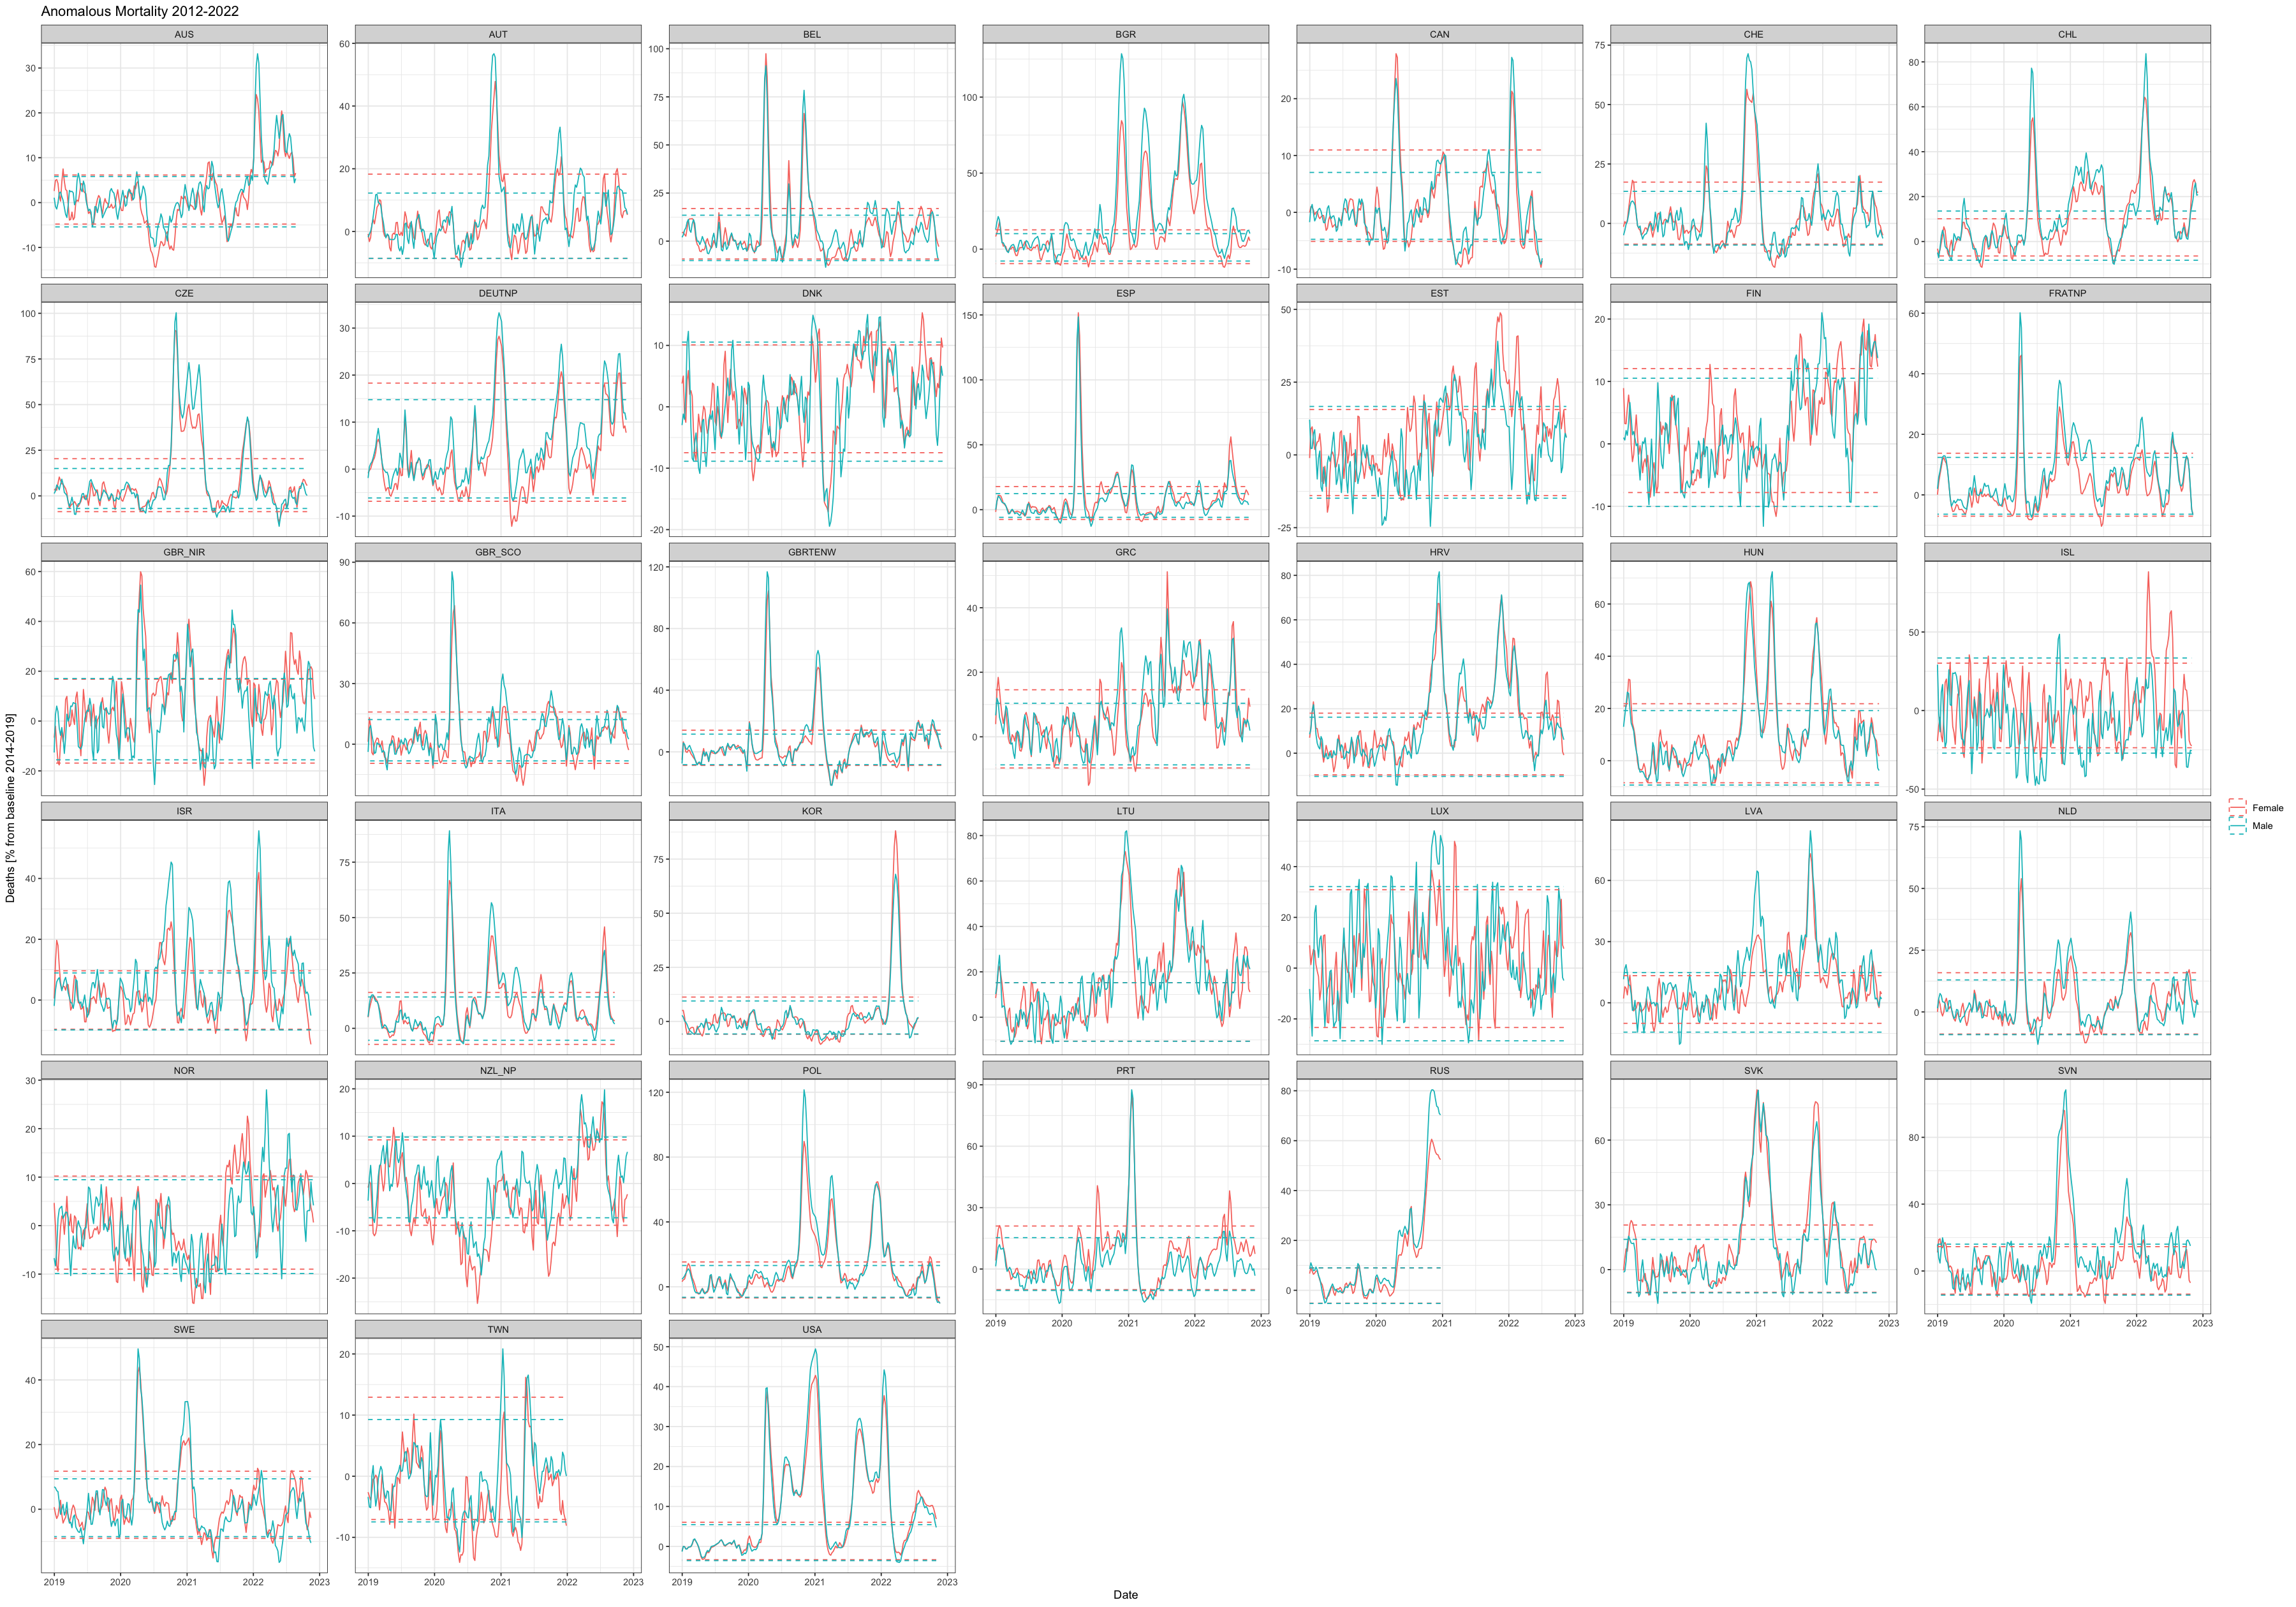

In [31]:
options(repr.plot.width=30, repr.plot.height=21)
p = ggplot(subset(high_ages_df, sex != "b" & year >= 2019), aes(date, get_percentage(centered)), color=sex) + geom_line(aes(color=sex)) + 
# geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high), color=sex), alpha=0, linetype=2) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~country, scales="free_y") + scale_color_discrete("", labels=c("Female", "Male"))
p
ggsave(p, file="../figures/all_countries_smooth_high_age_by_gender.pdf", width=25, height=10)

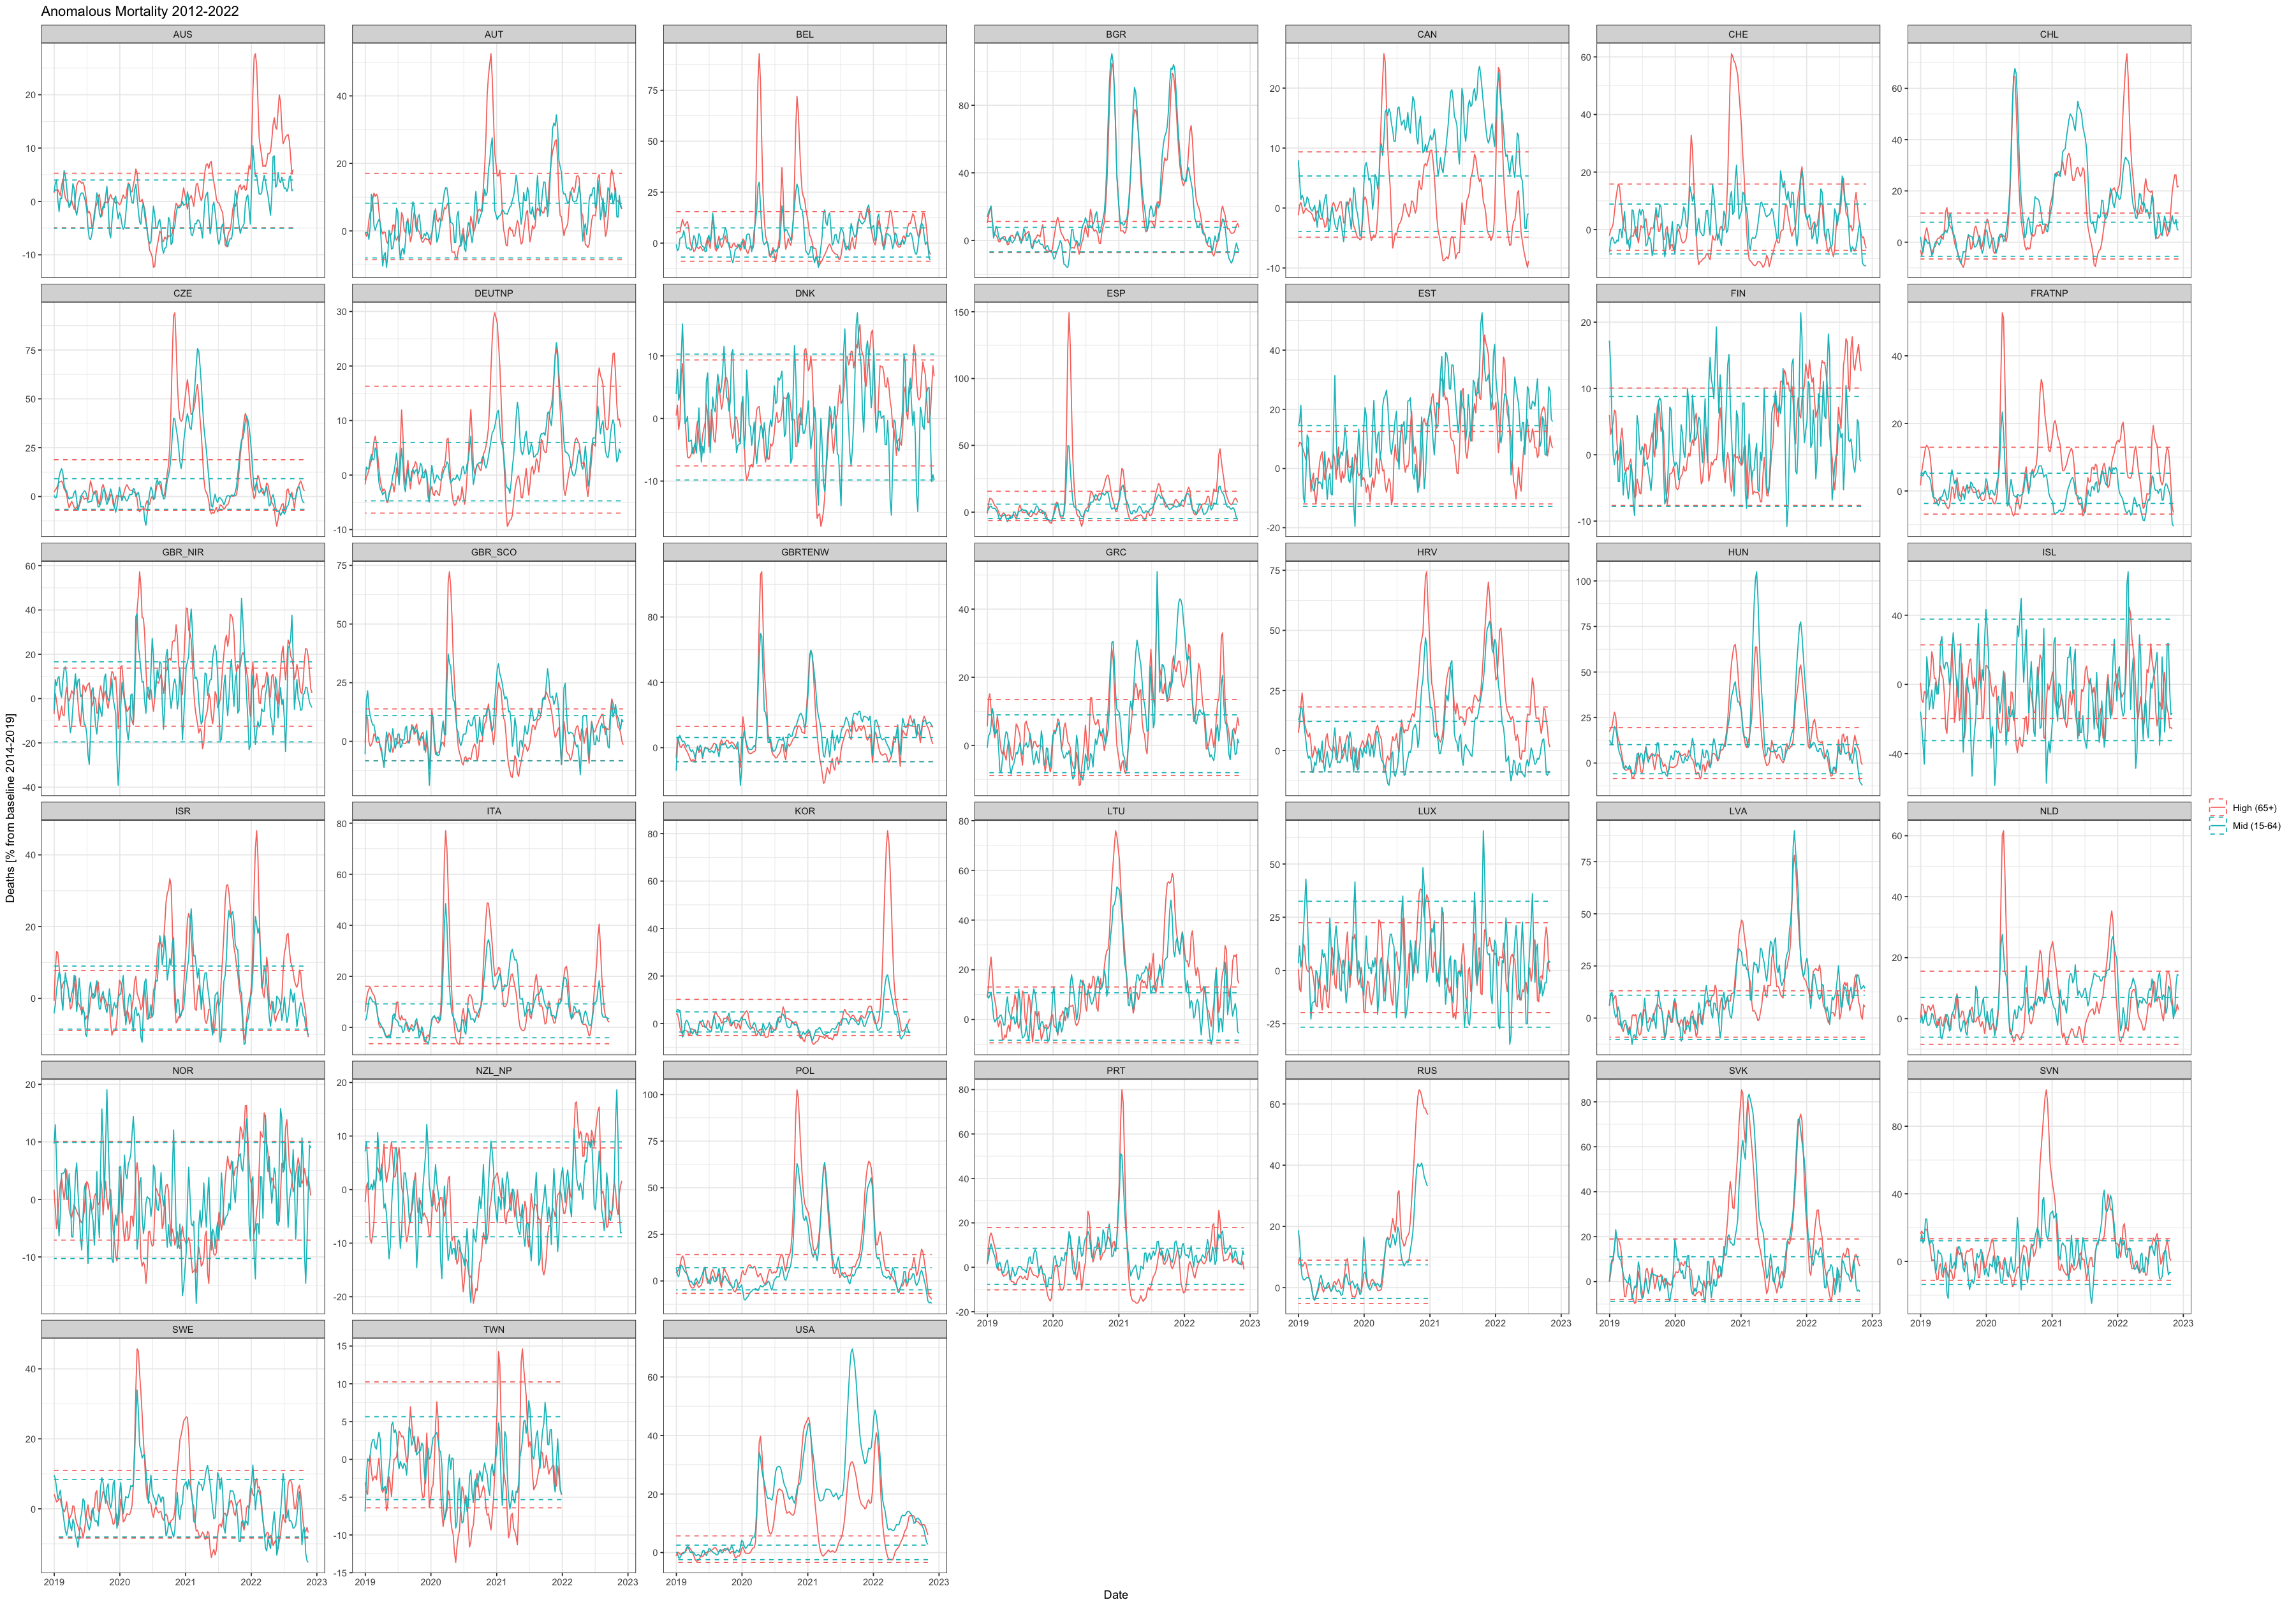

In [32]:
options(repr.plot.width=30, repr.plot.height=21)
p = ggplot(subset(all_ages_df, sex == "b" & year >= 2019), aes(date, get_percentage(centered)), color=age_group) + geom_line(aes(color=age_group)) + 
# geom_smooth(method="lm", formula=y ~ ns(x, df=16), se=FALSE) +
geom_ribbon(aes(ymin=get_percentage(centered_low), ymax=get_percentage(centered_high), color=age_group), alpha=0, linetype=2) + 
labs(x="Date", y="Deaths [% from baseline 2014-2019]", title="Anomalous Mortality 2012-2022") + 
facet_wrap(~country, scales="free_y") + scale_color_discrete("", labels=c("High (65+)", "Mid (15-64)"))
p
ggsave(p, file="../figures/all_countries_smooth_both_gender_by_age_type.pdf", width=25, height=10)

[1] "Using 2 degrees of freedom in yearly splines for USA, 15-64, b"


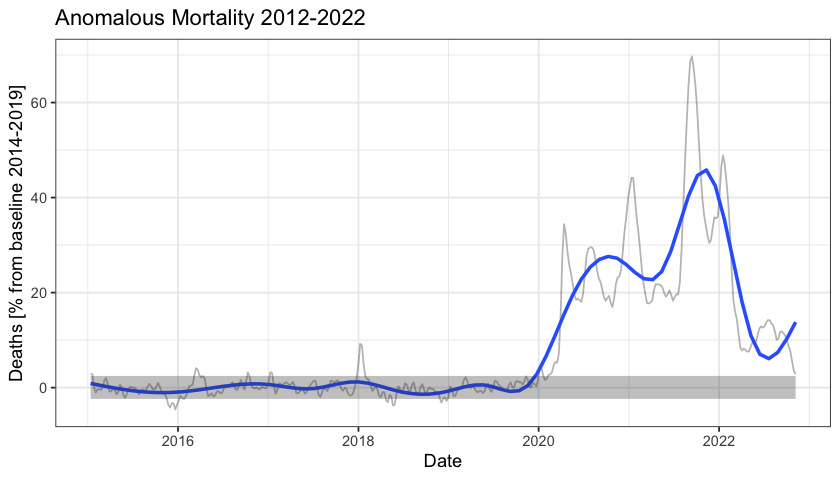

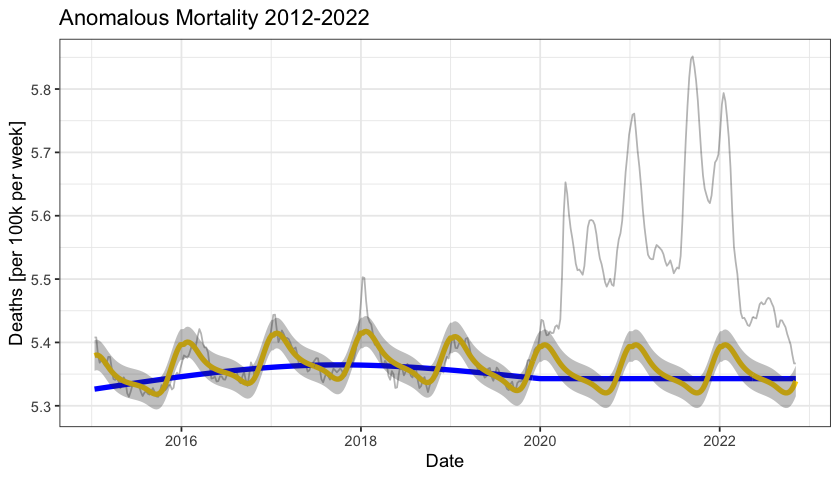

In [58]:
# Fit single country and sex
options(repr.plot.width=7, repr.plot.height=4)
cdata = subset(mid_ages, CountryCode=="USA" & Sex=="b")
all = mortality_fit(cdata)
plot_mortality(all)
plot_debug(all)

In [59]:
# Write data for possible further analysis.
head(all_ages_df)
write.csv(all_ages_df, "../data/mortality_all_ages_normalized.csv")
write.csv(stratified, "../data/mortality_stratified_normalized.csv")

date       week year response sex country age pop             
high.Sex1 2015-01-05 1    2015 6.060220 b   AUS     65+ 47428.5359615384
high.Sex2 2015-01-12 2    2015 6.060220 b   AUS     65+ 47428.5359615384
high.Sex3 2015-01-19 3    2015 6.058590 b   AUS     65+ 47428.5359615384
high.Sex4 2015-01-26 4    2015 6.050041 b   AUS     65+ 47428.5359615384
high.Sex5 2015-02-02 5    2015 6.054867 b   AUS     65+ 47428.5359615384
high.Sex6 2015-02-09 6    2015 6.069741 b   AUS     65+ 47428.5359615384
          fit.yearly fit.weekly  centered    centered_high centered_low
high.Sex1 6.107542   -0.06369971 0.016377851 0.05020863    -0.05090514 
high.Sex2 6.107812   -0.06559003 0.017998527 0.05020863    -0.05090514 
high.Sex3 6.108081   -0.06673739 0.017246267 0.05020863    -0.05090514 
high.Sex4 6.108351   -0.06717730 0.008867439 0.05020863    -0.05090514 
high.Sex5 6.108620   -0.06694524 0.013192363 0.05020863    -0.05090514 
high.Sex6 6.108889   -0.06607671 0.026928196 0.05020863    -0.05090514 
          age_group
high.Sex1 high     
high.Sex2 high     
high.Sex3 high     
high.Sex4 high     
high.Sex5 high     
high.Sex6 high

In [60]:
# data[data["CountryCode"] == "NOR" & data["Sex"] == "b",] %>% group_by(Age) %>% mutate(pop=sum(Pop))
data[data["CountryCode"] == "NOR" & data["Sex"] == "b" & data["Age"] == "15_64",]

Age   CountryCode Weekdate   Year Week Sex DTotal RTotal      Split
1    15_64 NOR         2000-W01-7 2000 01   b   1296   0.015003914 0    
2    15_64 NOR         2000-W02-7 2000 02   b   1219   0.014112478 0    
3    15_64 NOR         2000-W03-7 2000 03   b   1073   0.012422222 0    
4    15_64 NOR         2000-W04-7 2000 04   b   1044   0.012086487 0    
5    15_64 NOR         2000-W05-7 2000 05   b    978   0.011322398 0    
6    15_64 NOR         2000-W06-7 2000 06   b    941   0.010894046 0    
7    15_64 NOR         2000-W07-7 2000 07   b    932   0.010789852 0    
8    15_64 NOR         2000-W08-7 2000 08   b    884   0.010234151 0    
9    15_64 NOR         2000-W09-7 2000 09   b    872   0.010095226 0    
10   15_64 NOR         2000-W10-7 2000 10   b    832   0.009632143 0    
11   15_64 NOR         2000-W11-7 2000 11   b    821   0.009504794 0    
12   15_64 NOR         2000-W12-7 2000 12   b    769   0.008902786 0    
13   15_64 NOR         2000-W13-7 2000 13   b    808   0.009354292 0    
14   15_64 NOR         2000-W14-7 2000 14   b    775   0.008972248 0    
15   15_64 NOR         2000-W15-7 2000 15   b    823   0.009527949 0    
16   15_64 NOR         2000-W16-7 2000 16   b    830   0.009608988 0    
17   15_64 NOR         2000-W17-7 2000 17   b    781   0.009041711 0    
18   15_64 NOR         2000-W18-7 2000 18   b    786   0.009099596 0    
19   15_64 NOR         2000-W19-7 2000 19   b    807   0.009342715 0    
20   15_64 NOR         2000-W20-7 2000 20   b    764   0.008844900 0    
21   15_64 NOR         2000-W21-7 2000 21   b    782   0.009053288 0    
22   15_64 NOR         2000-W22-7 2000 22   b    780   0.009030134 0    
23   15_64 NOR         2000-W23-7 2000 23   b    865   0.010014187 0    
24   15_64 NOR         2000-W24-7 2000 24   b    842   0.009747913 0    
25   15_64 NOR         2000-W25-7 2000 25   b    796   0.009215367 0    
26   15_64 NOR         2000-W26-7 2000 26   b    760   0.008798592 0    
27   15_64 NOR         2000-W27-7 2000 27   b    811   0.009389024 0    
28   15_64 NOR         2000-W28-7 2000 28   b    817   0.009458486 0    
29   15_64 NOR         2000-W29-7 2000 29   b    747   0.008648090 0    
30   15_64 NOR         2000-W30-7 2000 30   b    739   0.008555473 0    
⋮    ⋮     ⋮           ⋮          ⋮    ⋮    ⋮   ⋮      ⋮           ⋮    
1163 15_64 NOR         2022-W19-7 2022 19   b   831    0.007983572 0    
1164 15_64 NOR         2022-W20-7 2022 20   b   842    0.008089251 0    
1165 15_64 NOR         2022-W21-7 2022 21   b   750    0.007205390 0    
1166 15_64 NOR         2022-W22-7 2022 22   b   806    0.007743393 0    
1167 15_64 NOR         2022-W23-7 2022 23   b   777    0.007464784 0    
1168 15_64 NOR         2022-W24-7 2022 24   b   807    0.007753000 0    
1169 15_64 NOR         2022-W25-7 2022 25   b   891    0.008560004 0    
1170 15_64 NOR         2022-W26-7 2022 26   b   802    0.007704964 0    
1171 15_64 NOR         2022-W27-7 2022 27   b   856    0.008223752 0    
1172 15_64 NOR         2022-W28-7 2022 28   b   882    0.008473539 0    
1173 15_64 NOR         2022-W29-7 2022 29   b   866    0.008319824 0    
1174 15_64 NOR         2022-W30-7 2022 30   b   800    0.007685749 0    
1175 15_64 NOR         2022-W31-7 2022 31   b   813    0.007810643 0    
1176 15_64 NOR         2022-W32-7 2022 32   b   792    0.007608892 0    
1177 15_64 NOR         2022-W33-7 2022 33   b   822    0.007897108 0    
1178 15_64 NOR         2022-W34-7 2022 34   b   773    0.007426355 0    
1179 15_64 NOR         2022-W35-7 2022 35   b   765    0.007349498 0    
1180 15_64 NOR         2022-W36-7 2022 36   b   821    0.007887500 0    
1181 15_64 NOR         2022-W37-7 2022 37   b   800    0.007685749 0    
1182 15_64 NOR         2022-W38-7 2022 38   b   846    0.008127680 0    
1183 15_64 NOR         2022-W39-7 2022 39   b   841    0.008079644 0    
1184 15_64 NOR         2022-W40-7 2022 40   b   813    0.007810643 0    
1185 15_64 NOR         2022-W41-7 2022 41   b   857    0.008233